In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

In [8]:
df=pd.read_csv("AAPL_5Y.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-04-21,26.732500,26.732500,26.379999,26.4925,24.640911,126210000
1,2016-04-22,26.252501,26.620001,26.155001,26.4200,24.573479,134732400
2,2016-04-25,26.250000,26.412500,26.127501,26.2700,24.433960,112126400
3,2016-04-26,25.977501,26.325001,25.977501,26.0875,24.264212,224064800
4,2016-04-27,24.000000,24.677500,23.920000,24.4550,22.745811,458408400


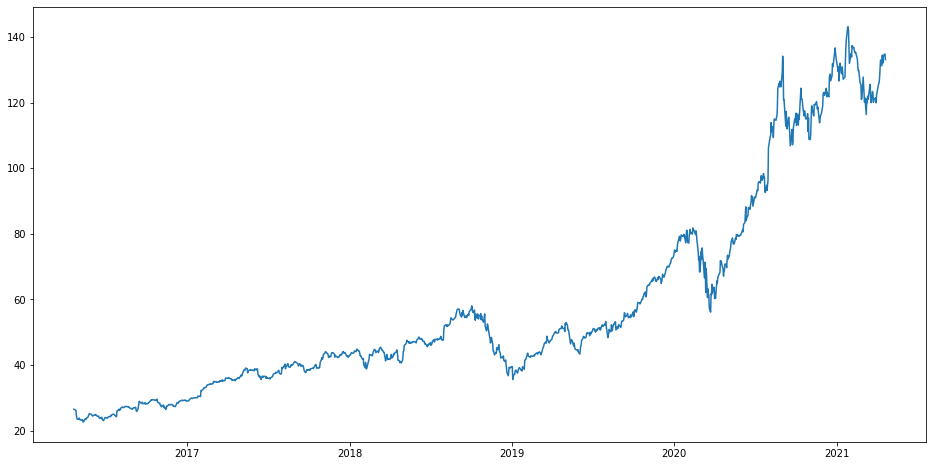

In [9]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [17]:
data = df.sort_index(ascending=True,axis=0)
df_new = pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
    df_new["Date"][i] = data['Date'][i]
    df_new["Close"][i] = data["Close"][i]
    
# print(df_new.head())
df_new.index = df_new.Date
df_new.drop("Date", axis=1, inplace=True)

final_dataset = df_new.values

train_data = final_dataset[0:1000,:]
valid_data = final_dataset[1000:,:]
print(train_data[-10:])
print()
print(valid_data[-10:])

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(final_dataset)

x_train_data,y_train_data = [],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data = np.array(x_train_data),np.array(y_train_data)

x_train_data = np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

[[61.935001]
 [63.702499]
 [63.572498]
 [60.227501]
 [61.232498]
 [60.352501]
 [65.6175]
 [64.857498]
 [66.517502]
 [66.997498]]

[[127.900002]
 [130.360001]
 [133.0]
 [131.240005]
 [134.429993]
 [132.029999]
 [134.5]
 [134.160004]
 [134.839996]
 [133.110001]]


In [11]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

940/940 - 9s - loss: 7.2598e-04


<ipython-input-12-4f43e34b8de2>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=closing_price


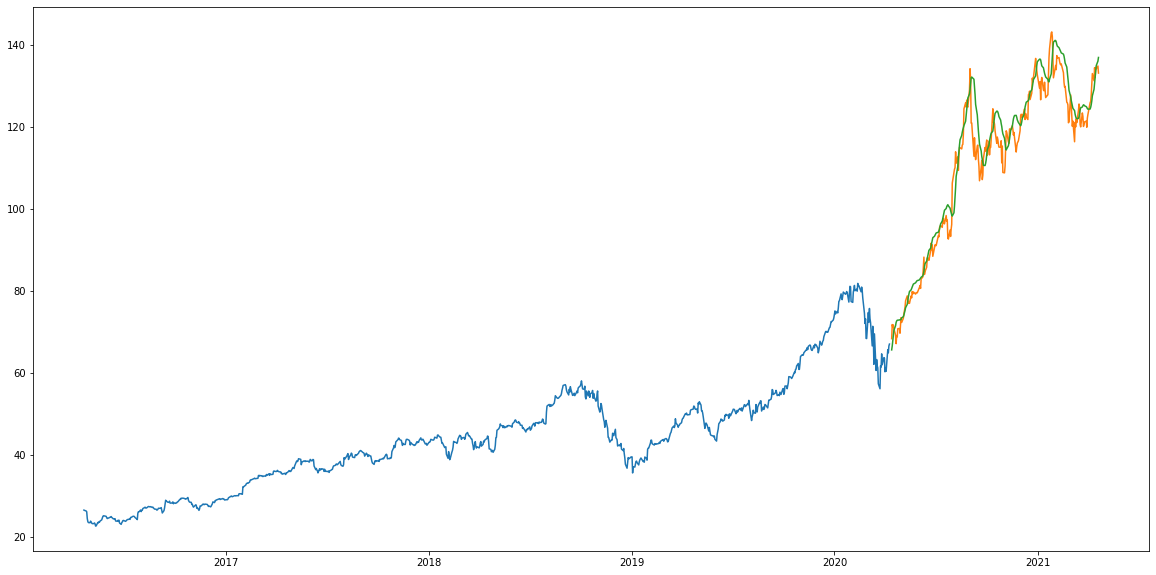

In [12]:
inputs_data = df_new[len(df_new)-len(valid_data)-60:].values
inputs_data = inputs_data.reshape(-1,1)
inputs_data = scaler.transform(inputs_data)


X_test = []
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
closing_price = lstm_model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

lstm_model.save("saved_lstm_model.h5")

train_data = df_new[:1000]
valid_data = df_new[1000:]
valid_data['Predictions'] = closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])